In [1]:
import pandas as pd
import glob
import os
import regex as re
import emoji
#import string
#import itertools
#import docx2txt
#from nltk.stem import WordNetLemmatizer
#from nltk import sent_tokenize, word_tokenize
#from spacy.lang.id import Indonesian
#from html import unescape
#from unidecode import unidecode
import pandas as pd
#from string import punctuation
#from bz2 import BZ2File as bz2
import numpy as np
import time
import seaborn as sns
import datetime
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
#from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("..\Data\Data Label\comments_Label_2000.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     2000 non-null   object 
 1   Tittle       2000 non-null   object 
 2   Name         2000 non-null   object 
 3   Comment      2000 non-null   object 
 4   Comment_Id   2000 non-null   object 
 5   Time         2000 non-null   object 
 6   Likes        2000 non-null   int64  
 7   Reply_Count  1647 non-null   float64
 8   Label        2000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 140.8+ KB


In [3]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [4]:
df.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0.0,spam
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0.0,legitimate
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0.0,legitimate
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0.0,legitimate
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0.0,legitimate


In [5]:
df.isnull().sum()

Video_Id         0
Tittle           0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    353
Label            0
dtype: int64

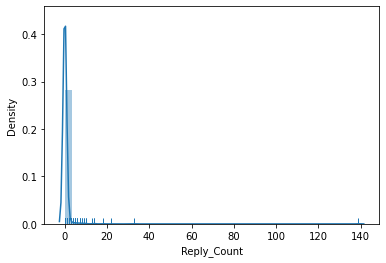

In [6]:
p = sns.distplot(df['Reply_Count'], kde=True, rug=True)

In [7]:
df['Reply_Count'].fillna(df['Reply_Count'].median(),inplace=True)

In [8]:
df.isnull().sum()

Video_Id       0
Tittle         0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [9]:
df["Reply_Count"] = df["Reply_Count"].astype("int64")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2000 non-null   object        
 1   Tittle       2000 non-null   object        
 2   Name         2000 non-null   object        
 3   Comment      2000 non-null   object        
 4   Comment_Id   2000 non-null   object        
 5   Time         2000 non-null   datetime64[ns]
 6   Likes        2000 non-null   int64         
 7   Reply_Count  2000 non-null   int64         
 8   Label        2000 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 127.2+ KB


In [11]:
#count comments words length
def count_length(text):
    return len(text)

In [12]:
df['Length_Comment'] = df['Comment'].apply(lambda x: count_length(x))

In [13]:
df.sample(5)

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
420,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Muhammad Arief Zaky,Konten ini lebih menghibur dan berbobot daripa...,UgyZ_t26GTtI649SpKR4AaABAg,2019-04-10 03:54:04,44,0,legitimate,87
32,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Ilham Satria,The best content everrrrr.........,UgyGpmStmBr9KtDb_yh4AaABAg,2020-06-13 15:01:09,148,0,legitimate,34
630,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,BORAX GAMING,Bapak Tau Apa Soal Ngantri,UgxfmxtD_0CUjTcxuih4AaABAg,2019-05-07 15:46:51,1,0,legitimate,26
1617,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Geoofanii FP,Saya datang dari masa lampau,UgxmFhJ5zp6mu2pk0eR4AaABAg,2019-04-13 11:57:34,1,0,legitimate,28
542,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,MASBOY 128,Pecah bngt,Ugz1KayX6uy63ak_8RR4AaABAg,2019-04-09 10:02:50,0,0,legitimate,10


## EDA

### Comments that got most 

In [10]:
like = df[df['Likes']==df['Likes'].max()]
print("Komentar dengan like terbanyak adalah {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah TERIMAKASIH SUDAH MENEMANI KAMI SEMUA SELAMA SEPULUH TAHUN

#thanksforskinnyindonesian24​


### 10 YouTube Account that comments have most reply

In [11]:
account = df['Name'].value_counts().head(10)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [12]:
data = df.copy()
times = data['Time']

In [13]:
def time(date):
    Time = date.time()
    return Time

data['Period'] = times.map(time)
data['Period'].head()

0    11:27:47
1    04:08:18
2    08:57:13
3    16:42:13
4    00:45:06
Name: Period, dtype: object

In [14]:
data1 = data.copy()

def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '12 AM - 1 AM'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '1 AM - 2 AM'
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '2 AM - 3 AM'
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '3 AM - 4AM'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '4 AM - 5AM'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '5 AM - 6 AM'
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '6 AM - 7 AM'
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '7 AM - 8 AM'
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '8 AM - 9 AM'
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '9 AM - 10 AM'
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10 AM - 11 AM'
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11 AM - 12PM'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12 PM - 1PM'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '1 PM - 2 PM'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '2 PM - 3 PM'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '3 PM - 4 PM'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '4 PM - 5 PM'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '5 PM - 6 PM'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '6 PM - 7 PM'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '7 PM - 8 PM'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '8 PM - 9 PM'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '9 PM - 10 PM'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '10 PM - 11 PM'
    elif time >= datetime.time(23,0) and time <= datetime.time(23,59):
        return '11 PM - 12 AM'
    else:
        return 'other'

In [15]:
data1["Period_groups"] = data1['Period'].map(time_groups)
data1.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Period,Period_groups
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,spam,11:27:47,11 AM - 12PM
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,04:08:18,4 AM - 5AM
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,08:57:13,8 AM - 9 AM
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,16:42:13,4 PM - 5 PM
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,00:45:06,12 AM - 1 AM


In [16]:
time_group = data1['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

## Cleaning Text

In [17]:
try_data_cleaning = df.copy()

In [18]:
try_data_cleaning

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,spam
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate
...,...,...,...,...,...,...,...,...,...
1995,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Inul Rosmeydar,"""Nih BPJS, ngantri lo sana"" :v",Ugxy8JCX7KI-f5xu_8V4AaABAg,2019-04-11 04:18:52,1,0,legitimate
1996,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,FAREL AKBAR ADITYA SARAGIH,Gua masih suka lihat ini,Ugz9_8SeFNbW0XDKetZ4AaABAg,2019-08-19 02:36:19,0,0,legitimate
1997,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Craft Lisin,Saya udah 5 kali nonton ini,Ugwc9smbDefrf_4gjSd4AaABAg,2019-04-18 06:07:50,1,0,legitimate
1998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,dahlia triyanti,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻,Ugznk3WicUm_9xAm4Zp4AaABAg,2019-04-12 08:26:32,0,0,legitimate


In [19]:
trial = try_data_cleaning[["Comment", "Label"]]

In [20]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()

In [21]:
Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)

In [26]:
#def openfile(path):
#    results = [] 
#    files = os.listdir(path)
#    for name in files:
#        results.append(name)
#    results.sort(reverse = True)

#    return(path+'/'+results[0])

In [27]:
#def crawlFiles(dPath, types = None):
    #dPath = 'C:/Temp', types ='pdf'
#    if types:
#        return [dPath+'/'+f for f in os.listdir(dPath) if f.endswith('.'+types)]
#    else:
#        return [dPath+'/'+f for f in os.listdir(dPath)]

#def readBz2(file):
#    with bz2(file, "r") as bzData:
#        txt = []
#        for line in bzData:
#            try:
#                txt.append(line.strip().decode('utf-8','replace'))
#            except:
#                pass
#    return ' '.join(txt)

#def LoadDocuments(dPath=None,types=None, file = None): # types = ['pdf','doc','docx','txt','bz2']
#    Files, Docs = [], []
#    if types:
#        for tipe in types:
#            Files += crawlFiles(dPath,tipe)
#    if file:
#        Files = [file]
#    if not types and not file: # get all files regardless of their extensions
#        Files += crawlFiles(dPath)
#    for f in Files:
#        if f[-3:].lower()=='pdf':
#            try:
#                Docs.append(PDF(f).string)
#            except:
#                print('error reading{0}'.format(f))
#       if f[-3:].lower()=='txt':
#            try:
#                df=open(f,"r",encoding="utf-8", errors='replace')
#                Docs.append(df.readlines());df.close()
#            except:
#                print('error reading{0}'.format(f))
#        elif f[-3:].lower()=='bz2':
#            try:
#                Docs.append(readBz2(f))
#            except:
#                print('error reading{0}'.format(f))
#        elif f[-4:].lower()=='docx':
#            try:
#                Docs.append(docx2txt.process(f))
#            except:
#                print('error reading{0}'.format(f))
#        elif f[-3:].lower()=='csv':
#            Docs.append(pd.read_csv(f))
#        else:
#            print('Unsupported format {0}'.format(f))
#    if file:
#        Docs = Docs[0]
#    return Docs, Files


#def LoadStopWords(lang, sentiment = True):
#    L = lang.lower().strip()
#    if sentiment:
#        if L == 'en' or L == 'english' or L == 'inggris':
#            lemmatizer = WordNetLemmatizer()
#            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = './CommentsDetection/Stopwords'))[0]])
#        elif L == 'id' or L == 'indonesia' or L == 'indonesian':
#            lemmatizer = Indonesian()
#            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = './CommentsDetection/Stopwords'))[0]])
#        else:
#            print('Warning! Languange not recognized. Empty stopword given')
#            stops = set(); lemmatizer = None
#    else:
#        if L == 'en' or L == 'english' or L == 'inggris':
#            lemmatizer = WordNetLemmatizer()
#            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = './CommentsDetection/Stopwords_eng'))[0]])
#        elif L == 'id' or L == 'indonesia' or L == 'indonesian':
#            lemmatizer = Indonesian()
#            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = './CommentsDetection/Stopwords'))[0]])
#        else:
#            print('Warning! Languange not recognized. Empty stopword given')
#           stops = set(); lemmatizer = None
#    return stops, lemmatizer

#def fixTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    pisahtags = re.compile(r'[A-Z][^A-Z]*')
#    t = T
#    tagS = re.findall(getHashtags, T)
#    for tag in tagS:
#        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
#       t = t.replace('#'+tag, proper_words)
#    return t

#def getTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    tagS = re.findall(getHashtags, T)
#    isitag = []
#    for tag in tagS:       
#        tag = '#'+tag
#        isitag.append(tag)
    
#    return ', '.join(isitag)

#def cleanText(T, fix={}, lang = 'id', lemma=None, stops = set(), symbols_remove = False, numbers_remove = False, hashtag_remove = False, min_charLen = 0):
    # lang & stopS only 2 options : 'en' atau 'id'
    # symbols ASCII atau alnum
#    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
#    t = T
#    t = re.sub(pattern,' ',t) #remove urls if any
#    t = unescape(t) # html entities fix
#    if hashtag_remove:
#        t = getTags(t) # fix abcDef
#    else:
#        t = t
#   t = t.lower().strip() # lowercase
#    t = unidecode(t)
#    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
#    t = sent_tokenize(t) # sentence segmentation. String to list
#    for i, K in enumerate(t):
#        if symbols_remove:
#            K = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',K)
#            K = K.replace(',',' ').replace('.',' ')
#            K = ''.join(c for c in K if c not in punctuation)
#            K = re.sub('\s+',' ',K).strip()
        
#        if numbers_remove:
#            K = re.sub(r'[0-9]',' ',K)
#           K = re.sub('\s+',' ',K)
            
#        cleanList = []
#        if lang =='en':
#            listKata = word_tokenize(K) # word tokenize
#            for token in listKata:
#                if token in fix.keys():
#                    token = fix[token]
#                if lemma:
#                    token = lemma.lemmatize(token)
#                if stops:
#                    if len(token)>=min_charLen and token not in stops:
#                        cleanList.append(token)
#                else:
#                    if len(token)>=min_charLen:
#                        cleanList.append(token)
#            t[i] = ' '.join(cleanList)
#        else:
#            if lemma:
#               K = lemma(K)
#                listKata = [token.text for token in K]
#            else:
#               listKata = TextBlob(K).words
#                
#            for token in listKata:
#                if token in fix.keys():
#                    token = fix[token]
                
#                if lemma:
#                    token = lemma(token)[0].lemma_
                    #token = stemmer.stem(token)
#                if stops:    
#                    if len(token)>=min_charLen and token not in stops:
#                        cleanList.append(token)
#                else:
#                    if len(token)>=min_charLen:
#                        cleanList.append(token)
#            t[i] = ' '.join(cleanList).lstrip()
#    return ' '.join(t) # Return kalimat lagi

#def cleanText_(T, fix={}, min_charLen = 0):
#    t = T
#    t = t.lower().strip() # lowercase
#    t = unidecode(t)
#    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
#    t = sent_tokenize(t) # sentence segmentation. String to list
#    for i, K in enumerate(t):
#        cleanList = []
#        listKata = TextBlob(K).words
#        for token in listKata:
#            if token in fix.keys():
#                token = fix[token]
#                cleanList.append(token)
#            else:
#                if len(token)>=min_charLen:
#                    cleanList.append(token)
#        t[i] = ' '.join(cleanList).lstrip()
#    return ' '.join(t) # Return kalimat lagi


#def handlingnegation (text):
#    match = re.compile(r'(tidak|kurang|bukan|jangan|tapi|tetapi) (\w+)').findall(text)
#    match = list(set(match))
#    for i,word in enumerate(match): 
#        if ' '.join(match[i]) in text:
#            kata = text.replace(' '.join(match[i]), str(match[i][0])+' '+'negx'+str(match[i][1]))
#            text = kata
#    return text

#def handlingporn (text):
#    match = re.compile(r'(video|foto|photo) (\w+)').findall(text)
#    match = list(set(match))
#    for i,word in enumerate(match): 
#        if ' '.join(match[i]) in text:
#            kata = text.replace(' '.join(match[i]), str(match[i][0])+' '+'pornx'+str(match[i][1]))
#            text = kata
#    return text


In [28]:
#def cleanningtext(data, both = True, onlyclean = False, sentiment = False):
#    print('Cleaning Text')
#    fSlang = openfile(path = 'Slangwords')
#    bahasa = 'id'
#    stops, lemmatizer = LoadStopWords(bahasa, sentiment = sentiment)
#    sw=open(fSlang,encoding='utf-8', errors ='ignore', mode='r');SlangS=sw.readlines();sw.close()
#    SlangS = {slang.strip().split(':')[0]:slang.strip().split(':')[1] for slang in SlangS}
  
#    start_time = time.time()
#    tqdm.pandas()
    
#    if both:
#        data['Comment'] = data['Comment'].astype('str')
#        data['Comment'] = data['Comment'].str.lower()
#        data = data[~data.Comment.str.contains('unavailable')]
#        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : cleanText(x,fix=SlangS, lang = bahasa, lemma=lemmatizer, stops = stops, symbols_remove = False, numbers_remove = False, hashtag_remove=False, min_charLen = 2))
#        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : handlingnegation(x))
        #data['cleaned_text'] = data['cleaned_text'].progress_apply(lambda x : tm.handlingporn(x))
#    elif onlyclean: 
#        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : cleanText(x, fix=SlangS, lang = bahasa, 
#                               lemma=lemmatizer, stops = stops, symbols_remove = True, numbers_remove = True, hashtag_remove=False, min_charLen = 3))
#    else:
#        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : handlingnegation(x))
    
#    data = data[data['cleaned_text'].notna()]
#    print("%s seconds" %(time.time()-start_time))
    
#    return data

In [29]:
#def cleaning(text):
#    text = str(text)
#    print(f"Text Original : {text}")

#    print("\n\n")

    #getHastags
#    getHashtags = re.compile(r"#(\w+)")
#    pisahtags = re.compile(r'[A-Z][^A-Z]*')
#    t = text
#    tagS = re.findall(getHashtags, text)
#    for tag in tagS:
#        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
#        t = t.replace('#'+tag, proper_words)

In [22]:
import emoji 

def lower(text):
    text = text.lower()
    return text
    
#def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_emoji(text):
    pattern = emoji.get_emoji_regexp()
    without_emoji = pattern.sub('', text)
    return without_emoji

#def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    return text

#Detect link and replace with url
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(text, replace):
    url_filtered_comment = re.sub(urlregex, replace,text)
    return url_filtered_comment

#remove punctuation
clean_spcl = re.compile('[/(){}\[\]\|!;]')
clean_symbol = re.compile('[^.,a-zA-Z0-9 \n\.]')

def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub('', text)
    return text

def white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    text = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return text

In [31]:
#urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

#def detecturl(comment):
#    url_filtered_comment = re.sub(urlregex, 'url', comment)
#    return url_filtered_comment

In [32]:
text = "http://Youtube.com"

In [33]:
clean_punct(text)

'httpYoutube.com'

In [34]:
detecturl(text,'url')

'url'

In [23]:
trial['cleaned'] = trial['Comment'].apply(lambda x: lower(x))

In [24]:
trial.tail(20)

,Comment,Label,cleaned
1980,"Merindingggg, mantaaap #trending",legitimate,"merindingggg, mantaaap #trending"
1981,"jokowi atau prabowo ,silahkan di pilih yang pe...",legitimate,"jokowi atau prabowo ,silahkan di pilih yang pe..."
1982,Ngakak jangan wkwk,legitimate,ngakak jangan wkwk
1983,Kerennn nihhhh,legitimate,kerennn nihhhh
1984,@Muhammad Alfan Dimas Abdillah lah emang nggak...,legitimate,@muhammad alfan dimas abdillah lah emang nggak...
1985,Berawal dari sebuah kotak kardus yang pke gembok,legitimate,berawal dari sebuah kotak kardus yang pke gembok
1986,Yg sampe skrg masi nonton video ini siapa? Pro...,spam,yg sampe skrg masi nonton video ini siapa? pro...
1987,Lu bisa apa?😃,legitimate,lu bisa apa?😃
1988,TERIMAKASIH SUDAH MENEMANI KAMI SEMUA SELAMA S...,legitimate,terimakasih sudah menemani kami semua selama s...
1989,2:26paling enak,legitimate,2:26paling enak


In [37]:
#trial['cleaned'] = trial['cleaned'].apply(lambda x: remove_numbers(x))

In [38]:
#trial.tail(20)

In [25]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: remove_emoji(x))

In [26]:
trial.tail(20)

,Comment,Label,cleaned
1980,"Merindingggg, mantaaap #trending",legitimate,"merindingggg, mantaaap #trending"
1981,"jokowi atau prabowo ,silahkan di pilih yang pe...",legitimate,"jokowi atau prabowo ,silahkan di pilih yang pe..."
1982,Ngakak jangan wkwk,legitimate,ngakak jangan wkwk
1983,Kerennn nihhhh,legitimate,kerennn nihhhh
1984,@Muhammad Alfan Dimas Abdillah lah emang nggak...,legitimate,@muhammad alfan dimas abdillah lah emang nggak...
1985,Berawal dari sebuah kotak kardus yang pke gembok,legitimate,berawal dari sebuah kotak kardus yang pke gembok
1986,Yg sampe skrg masi nonton video ini siapa? Pro...,spam,yg sampe skrg masi nonton video ini siapa? pro...
1987,Lu bisa apa?😃,legitimate,lu bisa apa?
1988,TERIMAKASIH SUDAH MENEMANI KAMI SEMUA SELAMA S...,legitimate,terimakasih sudah menemani kami semua selama s...
1989,2:26paling enak,legitimate,2:26paling enak


In [27]:
trial["cleaned"] = trial["cleaned"].apply(lambda x: detecturl(x, 'url'))

In [28]:
trial.head(20)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,spam,apa salah mobale lejen pak soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,dan golput itu apa
3,Keren!!,legitimate,keren!!
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih siapa presiden aku prabowo-sandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,gw ikuttt koment lohhh
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih. meskipun tiru tiru epic rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,"gw pendukung prabowo, tp gw tersinggungnya pas..."
9,Ada yang dari tahun 2025?🗿🔥,spam,ada yang dari tahun 2025?


In [29]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: clean_punct(x))

In [30]:
trial.head(10)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,spam,apa salah mobale lejen pak soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,dan golput itu apa
3,Keren!!,legitimate,keren
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih siapa presiden aku prabowosandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,gw ikuttt koment lohhh
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih. meskipun tiru tiru epic rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,"gw pendukung prabowo, tp gw tersinggungnya pas..."
9,Ada yang dari tahun 2025?🗿🔥,spam,ada yang dari tahun 2025


In [31]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: white_spaces(x))

In [32]:
trial.head(10)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,spam,apa salah mobale lejen pak soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,dan golput itu apa
3,Keren!!,legitimate,keren
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih siapa presiden aku prabowosandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,gw ikuttt koment lohhh
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih. meskipun tiru tiru epic rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,"gw pendukung prabowo, tp gw tersinggungnya pas..."
9,Ada yang dari tahun 2025?🗿🔥,spam,ada yang dari tahun 2025


In [33]:
trial['cleaned'].head(10)

0                  apa salah mobale lejen pak soekarno
1                                                     
2                                   dan golput itu apa
3                                                keren
4                pilih siapa presiden aku prabowosandi
5                                                  url
6                               gw ikuttt koment lohhh
7        bagus sih. meskipun tiru tiru epic rap battle
8    gw pendukung prabowo, tp gw tersinggungnya pas...
9                             ada yang dari tahun 2025
Name: cleaned, dtype: object

In [34]:
stopwords = set(Sastrawi_StopWords_id)

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

In [35]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: clean_stopwords(x))

In [36]:
trial.head(10)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,spam,apa salah mobale lejen pak soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,golput apa
3,Keren!!,legitimate,keren
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih siapa presiden aku prabowosandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,gw ikuttt koment lohhh
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih. meskipun tiru tiru epic rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,"gw pendukung prabowo, tp gw tersinggungnya pas..."
9,Ada yang dari tahun 2025?🗿🔥,spam,tahun 2025


In [38]:
text = "mobale lejen adalah seorang kapiten, I really like tomat"

In [39]:
def en_stopwords(text):
    df=open('..\Stopwords_eng\stopwords_en.txt',"r",encoding="utf-8", errors='replace')
    en_stop = df.readlines()
    df.close()
    en_stop = [t.strip().lower() for t in en_stop]
    en_stop = set(en_stop)
    text = ' '.join(word for word in text.split() if word not in en_stop) # hapus stopword dari kolom deskripsi
    return text
    
def id_stopwords(text):
    df=open('..\Stopwords\stopwords.txt',"r",encoding="utf-8", errors='replace')
    id_stop = df.readlines()
    df.close()
    id_stop = [t.strip().lower() for t in id_stop]
    id_stop = set(id_stop)
    text = ' '.join(word for word in text.split() if word not in id_stop) # hapus stopword dari kolom deskripsi
    return text

In [40]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: en_stopwords(x))
trial['cleaned'] = trial['cleaned'].apply(lambda x: id_stopwords(x))

In [42]:
trial.head(10)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,spam,salah mobale lejen soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,golput
3,Keren!!,legitimate,keren
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih presiden aku prabowosandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,gw ikuttt koment
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih. tiru tiru epic rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,"gw pendukung prabowo, gw tersinggungnya flow j..."
9,Ada yang dari tahun 2025?🗿🔥,spam,tahun 2025


In [43]:
def slang(text):
    df=open('../Slangwords/slangwords.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines()
    slangS = [t.split(":") for t in slangS]
    slangS = [[k.strip(), v.strip()] for k,v in slangS]
    slangS = {k:v for k,v in slangS}

    T = TextBlob(text).words
    
    for i,t in enumerate(T):
        if t in slangS.keys():
            T[i] = slangS[t]
        
    T =' '.join(T)

    return T

In [44]:
trial['cleaned'] = trial['cleaned'].apply(lambda x: slang(x))

In [58]:
trial.head(20)

,Comment,Label,cleaned
0,Apa salah mobale lejen pak soekarno,legitimate,salah mobile legend soekarno
1,👆👆👆👆👆👆,legitimate,
2,Dan golput itu apa,legitimate,golput
3,Keren!!,legitimate,keren
4,Pilih siapa presiden aku Prabowo-Sandi,legitimate,pilih presiden prabowo sandi
5,https://youtu.be/LBKGyxnpMCU,spam,url
6,Gw ikuttt koment lohhh,spam,saya ikut komentar
7,Bagus sih. Meskipun tiru tiru Epic Rap Battle,legitimate,bagus sih meniru meniru epik rap battle
8,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",legitimate,saya pendukung prabowo saya tersinggungnya men...
9,Ada yang dari tahun 2025?🗿🔥,spam,tahun 2025


In [45]:
a = list(trial.cleaned)

In [46]:
a

['salah mobile legend soekarno',
 '',
 'golput',
 'keren',
 'pilih presiden aku prabowo sandi',
 'url',
 'saya ikut komentar',
 'bagus sih meniru meniru epik rap battle',
 'saya pendukung prabowo saya tersinggungnya mengalir jokowi',
 'tahun 2025',
 'menghibur',
 'aku 3 kali nonton lebih aku tidak',
 'saya sadar saya nonton 15 kali',
 'saya cocok menit 113 disitu bendera indonesia kaya setara dudukin selebihnya matap',
 'bagus banget keren',
 'aku gak suka aku',
 'mantap betul',
 'mantap kaum',
 'trandingkan geser pop pok pop',
 'bangga jangan golput',
 '152 siap',
 'saya',
 '7 tahun youtube skinnyindonesisan24',
 'keren banget',
 'nurhadi aldo',
 'tidak kabarnya papua dibohongin bbm tunggu tanggal mainnya menang rakyat hasil pencitraan',
 'pegang posisi trendingg brayy terbaik skinny',
 'tidak nyangka 2 tahun',
 'mantap',
 'keren',
 'baca bacain komentar lihat dikit populasi cebong gatau kenapa sadar 4,5th dibohongin janji janji salam akal sehat pas02',
 'bingung tidak tangkap',
 'ter

In [47]:
'''Cleaning function'''
import emoji 

#lowering text
def lower(text):
    text = text.lower()
    return text
    
#def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

#removing emoticon
def remove_emoji(text):
    pattern = emoji.get_emoji_regexp()
    without_emoji = pattern.sub('', text)
    return without_emoji

#def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    return text

#Detect link and replace with url
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(text, replace):
    url_filtered_comment = re.sub(urlregex, replace,text)
    return url_filtered_comment

#remove punctuation
clean_spcl = re.compile('[/(){}\[\]\|!;]')
clean_symbol = re.compile('[^.,a-zA-Z0-9 \n\.]')

def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub('', text)
    return text

#checking white spaces and removing
def white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    text = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return text

#Stopwords    
stopwords = set(Sastrawi_StopWords_id)

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

  #english stopwords
def en_stopwords(text):
    df=open('..\Stopwords_eng\stopwords_en.txt',"r",encoding="utf-8", errors='replace')
    en_stop = df.readlines()
    df.close()
    en_stop = [t.strip().lower() for t in en_stop]
    en_stop = set(en_stop)
    text = ' '.join(word for word in text.split() if word not in en_stop) # hapus stopword dari kolom deskripsi
    return text

    #Indonesian Stopwords
def id_stopwords(text):
    df=open('..\Stopwords\stopwords.txt',"r",encoding="utf-8", errors='replace')
    id_stop = df.readlines()
    df.close()
    id_stop = [t.strip().lower() for t in id_stop]
    id_stop = set(id_stop)
    text = ' '.join(word for word in text.split() if word not in id_stop) # hapus stopword dari kolom deskripsi
    return text

#Slangwords
def slang(text):
    df=open('../Slangwords/slangwords.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines()
    slangS = [t.split(":") for t in slangS]
    slangS = [[k.strip(), v.strip()] for k,v in slangS]
    slangS = {k:v for k,v in slangS}

    T = TextBlob(text).words
    
    for i,t in enumerate(T):
        if t in slangS.keys():
            T[i] = slangS[t]
        
    T =' '.join(T)

    return T

In [50]:
try_data_cleaning['cleaned_comment'] = try_data_cleaning['Comment'].apply(lambda x: lower(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: remove_emoji(x))
try_data_cleaning["cleaned_comment"] = try_data_cleaning["cleaned_comment"].apply(lambda x: detecturl(x, 'url'))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: clean_punct(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: white_spaces(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: clean_stopwords(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: en_stopwords(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: id_stopwords(x))
try_data_cleaning['cleaned_comment'] = try_data_cleaning['cleaned_comment'].apply(lambda x: slang(x))

In [57]:
try_data_cleaning.head(50)

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,cleaned
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,spam,salah mobile legend soekarno
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,golput
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,keren
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,pilih presiden aku prabowo sandi
5,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,url
6,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,666ranger,Gw ikuttt koment lohhh,UgwKlaNqj0fQUpQ3Neh4AaABAg,2019-04-09 11:42:22,0,0,spam,saya ikut komentar
7,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Rizaldo Rizky Ramadhan,Bagus sih. Meskipun tiru tiru Epic Rap Battle,UgzulMMMFleZEE1lAO54AaABAg,2019-04-15 05:00:02,0,0,legitimate,bagus sih meniru meniru epik rap battle
8,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Ganis Fathoni,"Gw pendukung Prabowo, tp gw tersinggungnya pas...",UgxF1r9yMnMxyFDa4HJ4AaABAg,2019-04-09 07:28:57,0,0,legitimate,saya pendukung prabowo saya tersinggungnya men...
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,BotaksMan,Ada yang dari tahun 2025?🗿🔥,Ugx_s948xKTK9LlXF5F4AaABAg,2021-01-18 14:38:50,1,0,spam,tahun 2025


In [61]:
#convert text into lower case
#def convert_to_lower(text):
#    return text.lower()

#remove_numbers on text
#def remove_numbers(text):
#    number_pattern = r'\d+'
#    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
#    return without_number

#def remove_punctuation(text):
#    return text.translate(str.maketrans('', '', string.punctuation))

#Komentar spam cenderung memiliki jumlah spasi yang banyak 
#sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
#bagi pengguna yang membacanya

#def remove_extra_white_spaces(text):
#    single_char_pattern = re.compile(r'\s+')
#    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
#    return without_sc

#def remove_stopwords(text):
#    nlp = spacy.blank("id")
#    removed = []
#    stop_words = list(STOP_WORDS)
#    Teks = nlp(text)
#    #tokens = token.text(Teks)
#    for i in range(len(Teks)):
#        if Teks [i] not in stop_words:
#            removed.append(Teks[i])
#    return " ".join(removed)


## Feature Extraction

In [83]:
def url_ratio(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

def word_duplicate_ratio(text):
    try:
        unique_words = set()
        for d in text.split():
	        unique_words.add(d)
        td =[len(d) for d in unique_words]
        return len(unique_words)/sum(td)
    except:
        if sum(td) == 0:
            return(" ")

#def stopwords_ratio()

In [80]:
try_data_cleaning['cleaned_title'] = try_data_cleaning['Tittle'].apply(lambda x: clean_punct(x))

In [84]:
try_data_cleaning['Url_Ratio'] = try_data_cleaning['Comment'].apply(lambda x: url_ratio(x))
try_data_cleaning['Number_White_Space'] = try_data_cleaning['cleaned'].apply(lambda x: count_extra_white_spaces(x))
try_data_cleaning['World_Duplicate_Ratio'] = try_data_cleaning['cleaned'].apply(lambda x: word_duplicate_ratio(x))

In [85]:
try_data_cleaning

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,cleaned,cleaned_title,Url_Ratio,Number_White_Space,World_Duplicate_Ratio
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,spam,salah mobile legend soekarno,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,3,0.16
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,0,
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,golput,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,0,0.166667
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,keren,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,0,0.2
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,pilih presiden aku prabowo sandi,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,4,0.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Inul Rosmeydar,"""Nih BPJS, ngantri lo sana"" :v",Ugxy8JCX7KI-f5xu_8V4AaABAg,2019-04-11 04:18:52,1,0,legitimate,bpjs ngantri,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,1,0.181818
1996,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,FAREL AKBAR ADITYA SARAGIH,Gua masih suka lihat ini,Ugz9_8SeFNbW0XDKetZ4AaABAg,2019-08-19 02:36:19,0,0,legitimate,saya suka lihat,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,2,0.230769
1997,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Craft Lisin,Saya udah 5 kali nonton ini,Ugwc9smbDefrf_4gjSd4AaABAg,2019-04-18 06:07:50,1,0,legitimate,5 kali nonton,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,2,0.272727
1998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,dahlia triyanti,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻,Ugznk3WicUm_9xAm4Zp4AaABAg,2019-04-12 08:26:32,0,0,legitimate,pilih prabowo cores,SkinnyIndonesian24 Prabowo VS Jokowi Epic Ra...,0.0,2,0.176471
